##### Contenido bajo Creative Commons Attribution license CC-BY 4.0. (c) 2015 C. Cooper y O. Skurtys, código bajo licencia MIT. Basado en [CFDPython](https://github.com/barbagroup/CFDPython), CC-BY 4.0 L. Barba.

# Ecuaciones diferenciales parciales

¡Bienvenidos al cuarto laboratorio! En el laboratorio anterior vimos ecuaciones diferenciales ordinarias (EDO), donde la función desconocida depende de una sola variable. En las ecuaciones diferenciales parciales (EDP) esta función puede depender de cualquier número de variables. En este laboratorio vamos a aprender a resolver ecuaciones diferenciales parciales numéricamente.

Ya que vivimos en un mundo tridimensional, y además el tiempo pasa inexorablemente, encontramos EDPs en la mayoría de los modelos que usamos para simular fenómenos físicos: la ecuación de onda, de calor, electrodinámica, Navier-Stokes, etc. 

La clase pasada revisamos la discretización de EDPs usando la ecuación de convección y difusión en 1D como ejemplo, lo que repasaremos a continuación. En este laboratorio ustedes implementarán varias cosas: las ecuaciones de convección no lineal, difusión y Burgers en una dimensión. Como extra, implementarán las ecuaciones de convección no lineal y difusión en 2D, lo que pueden hacer fuera del horario de clases si es que no alcanzan.

## Teoría

### Discretización

Para repasar los principales conceptos, usaremos la ecuación de convección lineal en una dimensión:

\begin{equation}
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0.
\end{equation}

En este caso, existen dos derivadas: una temporal $(t)$ y otra espacial $(x)$, y necesitamos generar una malla que abarque ambas componentes:

<img src="mesh.png"width="300px">

En el laboratorio 2 vimos que podemos tratar las derivadas usando diferencia adelantada, centrada, o atrasada; por lo tanto, tenemos 6 combinaciones posibles de discretización. Por ejemplo, la discretización atrasada en espacio y adelantada en tiempo da la siguiente ecuación:

\begin{equation}
\frac{u_{i}^{n+1} - u_i^n}{\Delta t} + c \frac{u_{i+1}^{n} - u_i^n}{\Delta x},
\end{equation}

donde el subíndice $i$ recorre la componente espacial de la malla (con espaciamiento $\Delta x$) y el superíndice $n$ la componente temporal (con pasos de tiempo $\Delta t$). Podemos reescribir esta ecuación poniendo las incógnitas a la izquierda y lo conocido a la derecha:

\begin{equation}
u_{i}^{n+1} = u_i^n - \frac{c \Delta t}{\Delta x} \left( u_{i}^{n} - u_{i-1}^n \right)
\end{equation}

Gráficamente, podemos representar la ecuación de la siguiente forma:

<img src="stencil.png"width="200px">

### Ejemplo: una onda cuadrada

Vamos a calcular numéricamente la ecuación de convección lineal en un dominio entre 0 y 2, con $c=1$. La condición inicial es una función que vale 1 en todas partes, menos entre 0.5 y 1, donde es dos. Dibujemos la condición inicial.

(0, 2.5)

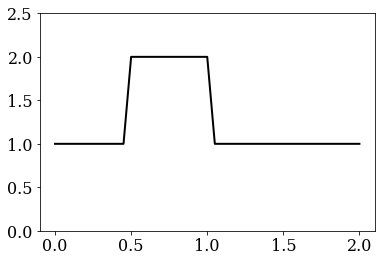

In [1]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

nx = 41
dx = 2./(nx-1)
x  = numpy.linspace(0, 2, nx) 

u_inicial = numpy.ones(nx)
u_inicial[int(0.5/dx):int(1/dx+1)] = 2.0
plt.plot(x, u_inicial, c='k', lw=2)
plt.ylim([0,2.5])

La ecuación de convección lineal es una forma de la ecuación de onda. Para una condición inicial $u_0(x)$ la solución exacta es $u(x-ct)$, por lo tanto, esperaríamos que esta función cuadrada se mueva hacia la derecha con velocidad $c$ manteniendo su forma: es una onda cuadrada. 

Evaluemos la función después de 20 pasos de tiempo a ver si es así. Para probar, usemos $\Delta t = 0.02$

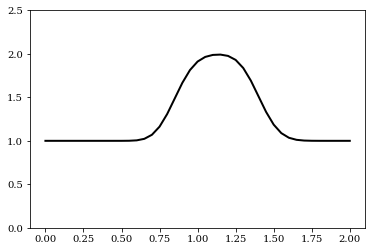

In [2]:
def ftbs(u, nt, nx, c, dt, dx):
    for n in range(1,nt):  
        un = u.copy() 
        for i in range(1,nx): 
            u[i] = un[i]-c*dt/dx*(un[i]-un[i-1])
    return u
            
nt = 20
dt = 0.02
c  = 1
u = u_inicial.copy()
u  = ftbs(u, nt, nx, c, dt, dx)
plt.plot(x, u, c='k', lw=2)
plt.ylim([0,2.5]);

La onda efectivamente se movió hace la derecha con una velocidad $c=1$, pero perdió su forma cuadrada por efectos de difusión numérica.

Al refinar la malla, la difusión numérica disminuye. Veremos más detalle de esto en clases.

### Condición Courant-Friedrichs-Lewy

Sería ideal que la solución avanzara más rápido. Del laboratorio 2 sabemos que la ecuación discretizada con diferencias adelantadas en tiempo cae como $\mathcal{O}(\Delta t)$, pero si no estamos tan preocupados de la exactitud, podemos aumentar $\Delta t$ para obtener la solución antes ¿Existe algún límite para esto? Probemos $\Delta t = 0.1$

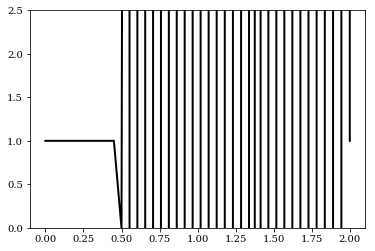

In [3]:
dt = 0.1
u = u_inicial.copy()
u  = ftbs(u, nt, nx, c, dt, dx)
plt.plot(x, u, c='k', lw=2)
plt.ylim([0,2.5]);

¡Algo anda claramente mal! ¿Por qué no funciona para estos parámetros? 

La razón es que la solución numérica se torna inestable para $\sigma = \frac{c\Delta t}{\Delta x}>1$, donde $\sigma$ es el número de Courant. Esto se conoce como la condición CFL.

En este caso $\sigma = \frac{1\cdot0.1}{\frac{2}{40}} = 2$, por lo tanto la solución numérica es inestable. Prueben con otros valores de $\Delta t$ para convencerse, y veremos la teoría detrás en clases.

## Ahora les toca a ustedes

### Convección no lineal

La ecuación de convección no lineal es

\begin{equation}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0.
\end{equation}

Como ven, es muy parecida al caso lineal, sin embargo, en vez de tener una velocidad constante $c$, ésta es $u$. Para el caso lineal, la onda cuadrada se movía hacia la derecha con velocidad $c$ ¿Qué creen ustedes que pasará ahora?

Al discretizar con diferencia adelantada en el tiempo y atrasada en el espacio, nos queda:

\begin{equation}
\frac{u_{i}^{n+1} - u_i^n}{\Delta t} + u_i \frac{u_{i+1}^{n} - u_i^n}{\Delta x},
\end{equation}

Implementen una función que evalúe la ecuación de convección no lineal para la onda cuadrada tras 20 pasos de tiempo con $\Delta t = 0.02$, con la misma malla que el caso lineal.

Comenten sobre la forma de la onda en el último paso de tiempo ¿Es diferente al caso lineal? ¿Por qué?

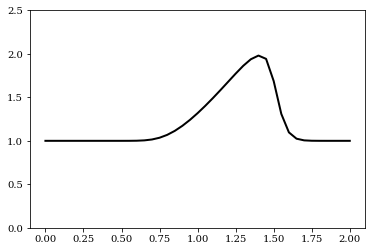

In [4]:
### ALUMNO
def ftbs_nl(u, nt, nx, dt, dx):
    for n in range(1,nt):  
        un = u.copy() 
        for i in range(1,nx): 
            u[i] = un[i]-un[i]*dt/dx*(un[i]-un[i-1])
    return u
#Hacer función para calcular caso nolineal 
###
nt=20
dt = 0.02
u = u_inicial.copy()
u  = ftbs_nl(u, nt, nx, dt, dx)
plt.plot(x, u, c='k', lw=2)
plt.ylim([0,2.5]);

### Difusión de la onda cuadrada

La ecuación de convección cae en la clasificación de ecuación hiperbólica. Otra familia de ecuaciones son las parabolicas, y el caso más conocido es la ecuación de difusión. En una dimensión ésta es:

\begin{equation}
\frac{\partial u}{\partial t} - \nu \frac{\partial² u}{\partial x²} = 0.
\end{equation}

Una aplicación común de la ecuación de difusión es la ecuación de conducción de calor, donde $u$ sería la temperatura. 

Vimos en el laboratorio 2 que la mejor manera de discretizar le segunda derivada era usando diferencia centrada. Así, la versión discretizada de la ecuación de difusión es:

\begin{equation}
\frac{u_{i}^{n+1} - u_i^n}{\Delta t} - \nu \frac{u_{i+1}^{n} - 2u_i^n + u_{i-1}^{n}}{(\Delta x)²} = 0.
\end{equation}

¿Qué pasa si la onda cuadrada se ve sujeta a difusión? Hagan una función que calcule esto numéricamente por 20 pasos de tiempo con $\Delta t=0.001$, y $\nu = 0.5$. Fíjense que en este caso necesitamos los dos puntos vecinos (el de adelante y atrás) ¿puede el `for` llegar hasta el final del arreglo?

La ecuación de difusión tiene su propia condición CFL:

\begin{equation}
\frac{\nu \Delta t}{(\Delta x)²} < \frac{1}{2}
\end{equation}

Cambien $\Delta t=0.005$ ¿Qué pasa? ¿Por qué?

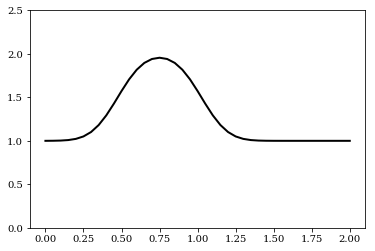

In [5]:
### ALUMNO
def ftcs(u, nt, nx, nu, dt, dx):
    for n in range(1,nt):  
        un = u.copy() 
        for i in range(1,nx-1): 
            u[i] = un[i]+nu*dt/dx**2*(un[i+1]-2*un[i]+un[i-1])
    return u
# Hacer función para ecuación de difusión
###
nt = 20
dt = 0.001
nu = 0.5
u = u_inicial.copy()
u  = ftcs(u, nt, nx, nu, dt, dx)
plt.plot(x, u, c='k', lw=2)
plt.ylim([0,2.5]);

## Combinando convección y difusión: ecuación de Burgers en 1-D

### La ecuación de Burgers

La ecuación de Burgers viscosa es una suma entre un término convectivo no-lineal y un término difusivo. Se escribe:

\begin{equation}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0,
\end{equation}

donde la no-linealidad está dada por que al lado de la derivada temporal hay una $u$ en vez de una constante $c$.

Esta ecuación es muy parecida a Navier-Stokes (sin el término de presión), y se usa mucho como una simplificación de ésta, por ejemplo, en estudios numéricos de turbulencia. 

La ecuación de Burgers discretizada con diferencia adelantada en el tiempo, atrasada en el espacio para la diferencial de primer orden, y centrada para la segunda derivada queda:

\begin{equation}
\frac{u_{i}^{n+1} - u_i^n}{\Delta t} + u_i^n \frac{u_{i}^{n} - u_{i-1}^n}{\Delta x} - \nu \frac{u_{i+1}^{n} - 2 u_i^n + u_{i+1}^{n}}{(\Delta x)^2} = 0.
\end{equation}

### Condiciones iniciales y de borde

Para este ejercicio, calcularemos la ecuación de Burgers en el dominio $[0,2\pi]$ con condición inicial:

\begin{eqnarray}
u &=& -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \\\
\phi(t=0) = \phi_0 &=& \exp \bigg(\frac{-x^2}{4 \nu} \bigg) + \exp \bigg(\frac{-(x-2 \pi)^2}{4 \nu} \bigg)
\end{eqnarray}

y condiciones de borde $u(0)=u(2\pi)$.

¿Ven algo raro en esas condiciones de borde? Más que especificar un valor para $u$ o su derivada, estamos diciendo que cualquiera sea el valor en el borde derecho, éste se traspasa al borde izquierdo. Esto se conoce como una condición de borde periódica, y es equivalente a decir que lo que pasa que el dominio se repite cada $2\pi$. En otras palabras, el punto en $0$ y en $2\pi$ son el mismo punto. Cuando implementen las condiciones de borde, piensen en quienes son los nodos vecinos del nodo en $0$ y $2\pi$.

La siguiente función es una implementación de la condición inicial:

In [6]:
from math import pi

def cond_inicial(x, nu):
    phi    = numpy.exp(-x*x/(4*nu)) + numpy.exp(-(x-2*pi)**2/(4*nu))
    dphidx = -x/(2*nu) * numpy.exp(-x*x/(4*nu)) + \
                -(x-2*pi)/(2*nu) * numpy.exp(-(x-2*pi)**2/(4*nu))
    
    return -2*nu/phi * dphidx + 4   

Grafiquémosla para tener una mejor idea. Usemos una malla con 101 nodos y $\nu=0.1$:

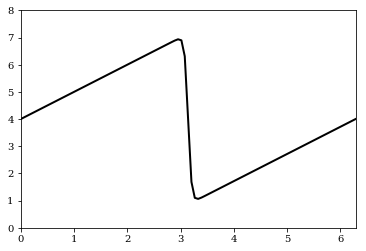

In [7]:
nx = 101
x  = numpy.linspace(0, 2*pi, nx)
nu = 0.1

u0 = cond_inicial(x, nu)

plt.plot(x, u0, c='k', lw=2)
plt.xlim([0,2*pi])
plt.ylim([0,8]);

### Solución analítica

La ecuación de Burgers con las condiciones iniciales y de borde descritas arriba tiene la siguiente solución analítica:

\begin{eqnarray}
u &=& -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \\\
\phi &=& \exp \bigg(\frac{-(x-4t)^2}{4 \nu (t+1)} \bigg) + \exp \bigg(\frac{-(x-4t -2 \pi)^2}{4 \nu(t+1)} \bigg)
\end{eqnarray}

Para ayudarlos un poco, les entregaremos una función que entrega la solución analítica dado $x$, $t$, y $\nu$:

In [8]:
def sol_analitica(x, t, nu):
    phi    = numpy.exp(-(x-4*t)**2/(4*nu*(t+1))) + numpy.exp(-(x-4*t-2*pi)**2/(4*nu*(t+1)))
    dphidx = -(x-4*t)/(2*nu*(t+1)) * numpy.exp(-(x-4*t)**2/(4*nu*(t+1))) + \
                -(x-4*t-2*pi)/(2*nu*(t+1)) * numpy.exp(-(x-4*t-2*pi)**2/(4*nu*(t+1)))
    
    return -2*nu/phi * dphidx + 4   

### Ejercicio

Compare con la solución analítica para mallas con 21, 41, 81 y 161 nodos y $\Delta t=0.001$ en el tiempo $t=0.5$ con $\nu=0.5$. Usen el error L2 (Laboratorio 2), y hagan un gráfico *log-log* comparando el error y $\Delta x$ para cada caso. ¿Cuál es el orden de aproximación con respecto a $\Delta x$? Considerando que tenemos aproximaciones de primer y segundo orden (derivada y segunda derivada) ¿Es lo que esperaba?

Cambien $\nu$ a $\nu=0.01$ y verán que la solución tiene una pendiente mayor. En un gráfico, sobreponga la solución analítica y la numérica para cada caso. ¿Es la solución numérica capaz de reproducir la forma "zig-zag" de la solución? ¿Por qué? ¿Cuál es la influencia de la malla en esto? Si grafican el error versus $\Delta x$ parece que el método ya no converge ¿Qué deben hacer para que si converja?

Cambien el valor de $\nu$ a $\nu=0.001$. ¿Qué ocurre? ¿Por qué es inestable si no hemos cambiado $\Delta t$ ni $\Delta x$? 

In [70]:
#### ALUMNO
def burgers(u, nu, dt, dx, nt):
    for n in range(1,nt):  
        un = u.copy() 
        for i in range(1,nx-1): 
            u[i] = un[i] - un[i]*dt/dx*(un[i]-un[i-1]) + nu*dt/dx**2*(un[i+1]-2*un[i]+un[i-1])
    return u
# Hacer función para calcular ecuación de Burger,
# grafique el error para cada caso.
####

#error
def L2_error(f_ap, f_an):
    num = numpy.zeros(len(f_ap))
    den = numpy.zeros(len(f_an))
    for i in range(len(num)):
        num[i] = (f_ap[i] - f_an[i])**2
        den[i] = f_an[i]**2   
    return numpy.sqrt(numpy.sum(num)/numpy.sum(den))

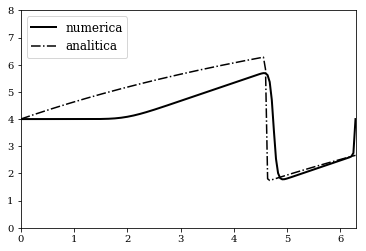

In [71]:
nx = 161
dx = 2.*pi/(nx-1)
x  = numpy.linspace(0, 2*pi, nx)
t  = numpy.linspace(0,0.5,nx)
nt = 500
dt = 0.001
nu = 0.01
u0 = cond_inicial(x, nu)
u = u0.copy()
u = burgers(u, nu, dt, dx, nt)
u_an = sol_analitica(x,t,nu)

#Grafico
from matplotlib import pyplot
plt.plot(x, u, c='k', lw=2,label='numerica')
plt.plot(x,u_an, c='k',ls='-.',label='analitica')
plt.xlim([0,2*pi])
plt.ylim([0,8]);
pyplot.legend(loc='best',prop={'size':12})

In [72]:
#Error
error=numpy.zeros(len(x))
for i in range(len(x)):
    error[i] = L2_error(u,u_an)
    
pyplot.loglog(h, error, c='k', ls='-')

## Extra: EDP en dos dimensiones

Como esfuerzo extra, vamos a revisar la solución de convección y difusión en dos dimensiones.

### Convección lineal

Veamos primero el caso de convección lineal. Vamos a usar la condición incial equivalente: una función cuadrada en 2 dimensiones, en un dominio $[0,2]\times[0,2]$, con condición inicial es $u=1$ en todas partes menos en $[0.5,1]\times[0.5,1]$, donde $u=2$. Usaremos $\Delta x = \Delta y = 0.02$ y $\Delta t = 0.005$, y graficaremos $u$ en $t=0.5$.

In [10]:
nx = 101
ny = 101
dx = 2./(nx-1)
dy = 2./(ny-1)
dt = 0.005
nt = int(0.5/dt)

x = numpy.linspace(0,2,nx)
y = numpy.linspace(0,2,ny)

u_inicial = numpy.ones((ny,nx)) 
u_inicial[int(.5/dy):int(1/dy+1),int(.5/dx):int(1/dx+1)]=2 

Para visualizar los resultados, usaremos una librería que grafica en 3D. Por ejemplo, la condición inicial se ve así:

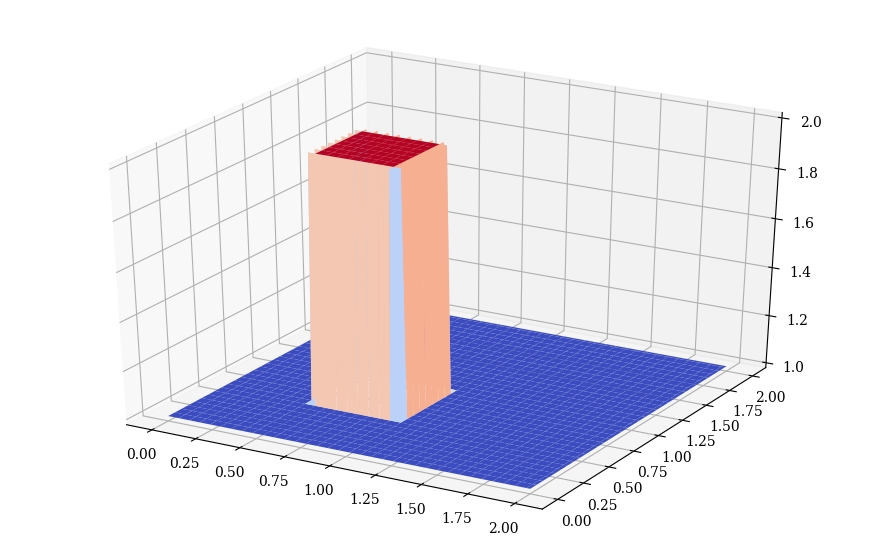

In [11]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(11,7), dpi=100)
ax = fig.gca(projection='3d')
X,Y = numpy.meshgrid(x,y)

ax.plot_surface(X,Y,u_inicial, cmap='coolwarm');

En 2 dimensiones, la ecuación de convección lineal es

\begin{equation}
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} + c\frac{\partial u}{\partial y} = 0
\end{equation}

la cual, al discretizar con diferencia adelantada en tiempo y atrasada en espacio, queda

\begin{equation}
\frac{u_{i,j}^{n+1}-u_{i,j}^n}{\Delta t} + c\frac{u_{i, j}^n-u_{i-1,j}^n}{\Delta x} + c\frac{u_{i,j}^n-u_{i,j-1}^n}{\Delta y}=0
\end{equation}

Donde $i$ recorre el eje $x$ y $j$ el eje $y$. 

Esta es una onda cuadrada similar al ejemplo que dimos al principio, pero en 2 dimensiones ¿En qué dirección creen ustedes que se moverá? ¿Por qué?

Comenten sobre la forma final de la onda ¿Por qué no mantiene su forma cuadrada?

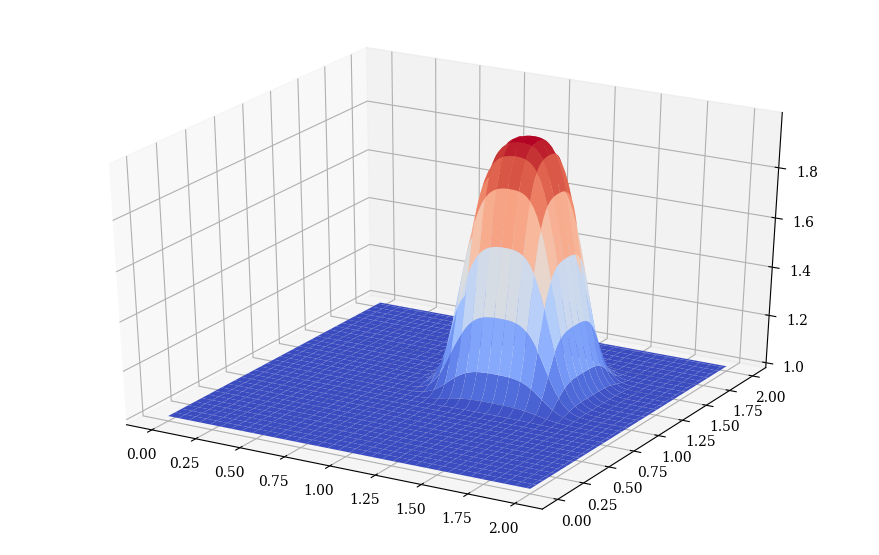

In [12]:
def ftbs2d(u, dx, dy, c, dt, nt):

    
    for n in range(nt+1): ##loop across number of time steps
        un = u.copy()
        row, col = u.shape
        for j in range(1, row):
            for i in range(1, col):
                u[j,i] = un[j, i] - (c*dt/dx*(un[j,i] - un[j,i-1]))-(c*dt/dy*(un[j,i]-un[j-1,i]))
                u[0,:] = 1
                u[-1,:] = 1
                u[:,0] = 1
                u[:,-1] = 1
            

    return u

c = 1
u = u_inicial.copy()
u = ftbs2d(u, dx, dy, c, dt, nt)

fig = plt.figure(figsize=(11,7), dpi=100)
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y,u, cmap='coolwarm');

### Convección no lineal

La ecuación de convección no lineal es un poco más complicada en 2D. En realidad, es un set de dos ecuaciones diferenciales parciales acopladas

\begin{align}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} &= 0 \\
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} &= 0
\end{align}

Discretizada con diferencia adelantada en tiempo y atrasada en espacio es:

\begin{align}
\frac{u_{i,j}^{n+1}-u_{i,j}^n}{\Delta t} + u_{i,j}^n \frac{u_{i,j}^n-u_{i-1,j}^n}{\Delta x} + v_{i,j}^n \frac{u_{i,j}^n-u_{i,j-1}^n}{\Delta y} &= 0 \\
\frac{v_{i,j}^{n+1}-v_{i,j}^n}{\Delta t} + u_{i,j}^n \frac{v_{i,j}^n-v_{i-1,j}^n}{\Delta x} + v_{i,j}^n \frac{v_{i,j}^n-v_{i,j-1}^n}{\Delta y} &= 0,
\end{align}

y despejando,

\begin{align}
u_{i,j}^{n+1} &= u_{i,j}^n - u_{i,j} \frac{\Delta t}{\Delta x} (u_{i,j}^n-u_{i-1,j}^n) - v_{i,j}^n \frac{\Delta t}{\Delta y} (u_{i,j}^n-u_{i,j-1}^n) \\
v_{i,j}^{n+1} &= v_{i,j}^n - u_{i,j} \frac{\Delta t}{\Delta x} (v_{i,j}^n-v_{i-1,j}^n) - v_{i,j}^n \frac{\Delta t}{\Delta y} (v_{i,j}^n-v_{i,j-1}^n).
\end{align}

Escriban una función que resuelva este set de ecuaciones acopladas, y grafiquen $\sqrt{u²+v²}$ para $t=0.5$, usando el mismo $\Delta t$ que antes. 

Como ven, es muy parecido al caso lineal, solamente que en la función vamos a evaluar dos ecuaciones en vez de una. La condición inicial de $v$ es la misma que $u$:

In [13]:
v_inicial = numpy.ones((ny,nx))
v_inicial[int(.5/dy):int(1/dy+1),int(.5/dx):int(1/dx+1)]=2

In [14]:
### ALUMNO
#def ftbs_2d(u, v, dx, dy, dt, nt):
#Escriba función para onda no lineal en 2D
###

### Difusión

Finalmente, la ecuación de difusión es

\begin{equation}
\frac{\partial u}{\partial t} - \nu \left(\frac{\partial² u}{\partial x²} + \frac{\partial² u}{\partial y²}\right) = 0,
\end{equation}

y se discretiza:

\begin{equation}
\frac{u_{i,j}^{n+1} - u_{i,j}^n}{\Delta t} = \nu \frac{u_{i+1,j}^n - 2 u_{i,j}^n + u_{i-1,j}^n}{\Delta x^2} + \nu \frac{u_{i,j+1}^n-2 u_{i,j}^n + u_{i,j-1}^n}{\Delta y^2}
\end{equation}

Escriban una función que calcule numéricamente esta ecuación para la condición inicial cuadrada con $\nu=0.5$, al tiempo $t=0.01$ y grafiquen. Como sabemos que la ecuación de difusión tiene una condición CFL más estricta, usaremos un paso de tiempo muy pequeño $\Delta t = 0.0001$ ¡La próxima semana veremos formas de evitar este problema!

In [15]:
###ALUMNO
#def diffuse(u, dx, dy, dt, nt, nu):
# Escriba función para ecuación de difusión en 2D
###